In [1]:
setwd("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/DIV28")
library(pheatmap)
library(RColorBrewer)
library(randomcoloR)
library(tidyverse)
library(reshape2)
library(umap)
library(dplyr)
library(proxy)
library(igraph)
custom.config <- umap.defaults
custom.config$random_state <- 123

Warning message:
"package 'randomcoloR' was built under R version 4.2.2"
Warning message:
"package 'tidyverse' was built under R version 4.2.3"
Warning message:
"package 'tibble' was built under R version 4.2.3"
Warning message:
"package 'tidyr' was built under R version 4.2.3"
Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'purrr' was built under R version 4.2.3"
Warning message:
"package 'dplyr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
Warning message:
"package 'forcats' was built under R version 4.2.3"
Warning message:
"package 'lubridate' was built under R version 4.2.3"
── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conf

In [2]:
packageVersion("MASS")

[1] '7.3.60'

In [ ]:
sessionInfo()

In [10]:
data<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/MEA_data/Processed/Well_summary_parameters_NB_hf_043_06_2025.csv") 
color<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/cell_lines/colors.csv")
data<-data[-1]
dim(data)

[1] 4114   49

In [11]:
data<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/MEA_data/Processed/Well_summary_parameters_NB_hf_043_06_2025.csv") 
color<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/cell_lines/colors.csv")
data<-data[-1]
data$color<-color$Color[match(data$Phenotype,color$Phenotype)]
data<-data[data$DIV_range=="DIV28",]
rownames(data)<-data$Unique_ID
data$NB_rate<-data$hf_and_NB_rate - data$hfNB_rate
#Remove the column 'column_name'
data <- data %>% select(-hf_and_NB_rate)
#Fix the problem with the dravet lines, FS is a different NDD
data$Syndrome<-ifelse(data$Phenotype=="FAM001_FS","FS",data$Syndrome)

In [3]:
#use now cell_line_v2 instead of Phenotype

In [12]:
cell_lines<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/cell_lines/cell_lines.csv")


In [13]:
data$cell_line<-cell_lines$cell_line_v2[match(data$Phenotype,cell_lines$Phenotype)]
color$cell_line<-cell_lines$cell_line_v2[match(color$Phenotype,cell_lines$Phenotype)]#
data$cell_line<-factor(data$cell_line, levels=cell_lines$order)

In [14]:
phenotype_colors <- setNames(color$Color, color$cell_line)

# Create a named vector for Syndromes and their corresponding MainColors
syndrome_colors <- setNames(color$MainColor, color$Syndrome)

In [15]:
data<-droplevels(data)


In [16]:
dim(data)

[1] 1515   51

In [17]:
#split patients / controls!
patients<-data[which(data$Syndrome !="Control"), ]
controls<-data[which(data$Syndrome =="Control"), ]

patients<-droplevels(patients)
controls<-droplevels(controls)

In [18]:
dim(patients)

[1] 944  51

In [19]:
dim(controls)

[1] 571  51

In [22]:
#head(patients)
length(levels(factor(patients$cell_line)))

[1] 44

In [9]:
pca_meta_controls <- controls %>%
 select(where(is.factor) | where(is.character))
set.seed(1)

pca_fit_controls <- controls %>%
  select(where(is.numeric))
pca_fit_controls<- prcomp(pca_fit_controls, center = TRUE,scale. = TRUE)
# pca_fit_controls$rotation <- -1*pca_fit_controls$rotation
summ <- summary(pca_fit_controls)
summ_var<-summ$importance[2,]
summ_var<-unname(summ_var[1:25])

pdf("variance_plot_controls.pdf", width = 7, height = 5)  # you can change size if needed

# Make the plot
plot(summ_var * 100, type = "b", pch = 19, col = "black",
     xlab = "Principal Component", ylab = "Variance (%)")

# Add a horizontal line at 1%
abline(h = 1, col = "blue", lty = 2, lwd = 2)

dev.off()

pdf 
  2

In [10]:
# Extract the loadings (rotation matrix)
loadings <- pca_fit_controls$rotation
# Extract the proportion of variance explained by each component
explained_variance <- pca_fit_controls$sdev^2 / sum(pca_fit_controls$sdev^2)
setNames(explained_variance, seq_along(explained_variance))

threshold<-0.01 #1% 
# Find the components that explain the least variance (most consistent)
selected_components  <- which(explained_variance <= threshold)
selected_components
length(selected_components)
# Initialize a list to store selected variables
selected_variables <- list()

# For each selected component, identify the top contributing variables
for (comp in selected_components) {
  component_loadings <- loadings[, comp]
  # Select variables with high absolute loadings (e.g., top 5)
  top_variables <- order(abs(component_loadings), decreasing = TRUE)[1:4]
  selected_variables[[paste0("PC", comp)]] <- names(component_loadings)[top_variables]
}

# Combine the selected variables from each component
final_selected_variables <- unique(unlist(selected_variables))

print("Selected Consistent Variables:")
print(final_selected_variables)

1            2            3            4            5            6 
0.3250755705 0.1532650822 0.1140508064 0.0911888574 0.0530826645 0.0479406171 
           7            8            9           10           11           12 
0.0386575076 0.0337762204 0.0253089307 0.0191852740 0.0186482191 0.0150942705 
          13           14           15           16           17           18 
0.0137726987 0.0113790273 0.0090324737 0.0069891488 0.0058584261 0.0047749234 
          19           20           21           22           23           24 
0.0043329006 0.0028679362 0.0023704250 0.0015442314 0.0008957796 0.0005913358 
          25 
0.0003166732

[1] 15 16 17 18 19 20 21 22 23 24 25

[1] 11

[1] "Selected Consistent Variables:"
 [1] "INBI"                 "IEBI_CV"              "EB_prop"             
 [4] "INBI_Std"             "EB_rate_Std"          "EB_ISI"              
 [7] "Firing_rate_Hz"       "NB_rate"              "Spikes_per_EB_Std"   
[10] "EB_rate_Hz"           "EB_Dur"               "EB_prop_Std"         
[13] "NB_dur"               "Spikes_per_EB"        "EB_Dur_Std"          
[16] "Firing_Rate_in_NB_Hz" "IEBI"                 "IEBI_Std"            
[19] "NB_prop"              "hfNB_and_NB_prop"     "hfNB_rate"           


In [11]:
write.csv(final_selected_variables,"final_selected_variables_001_top4.csv")

In [12]:
all_variables<-controls %>%
  select(where(is.numeric)) %>% colnames()
write.csv(all_variables,"all_MEA_variables.csv")

In [13]:
#PCA controls

In [14]:
pca_fit_controls <- controls[final_selected_variables]
pca_fit_controls<- prcomp(pca_fit_controls, center = TRUE,scale. = TRUE)
# pca_fit_controls$rotation <- -1*pca_fit_controls$rotation
summ <- summary(pca_fit_controls)
summ_var<-summ$importance[2,]
summ_var<-unname(summ_var[1:21])

In [15]:
pca_pc_metrics<-as.data.frame(pca_fit_controls$x)
pca_pc_metrics$Unique_ID<-rownames(pca_pc_metrics)
pca_pc_metrics<-inner_join(pca_pc_metrics,pca_meta_controls, by="Unique_ID")
rownames(pca_pc_metrics)<-pca_pc_metrics$Unique_ID
var_explained =round((pca_fit_controls$sdev^2 / sum(pca_fit_controls$sdev^2))*100,2)

In [16]:
set.seed(3) 
n_colors=16                                          # Set random seed
palette16 <- distinctColorPalette(n_colors)

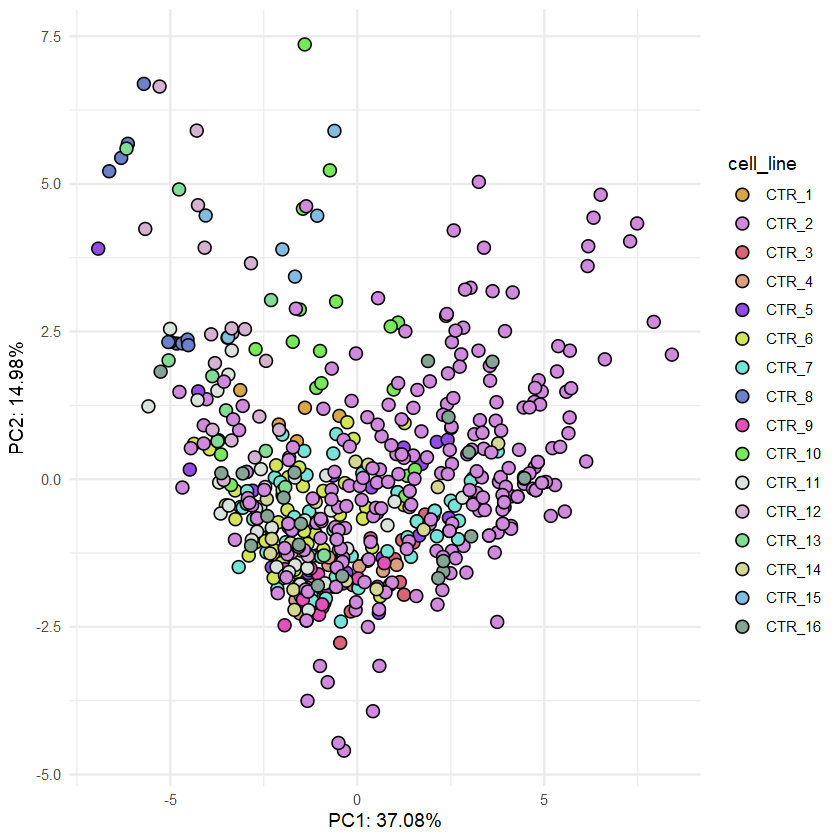

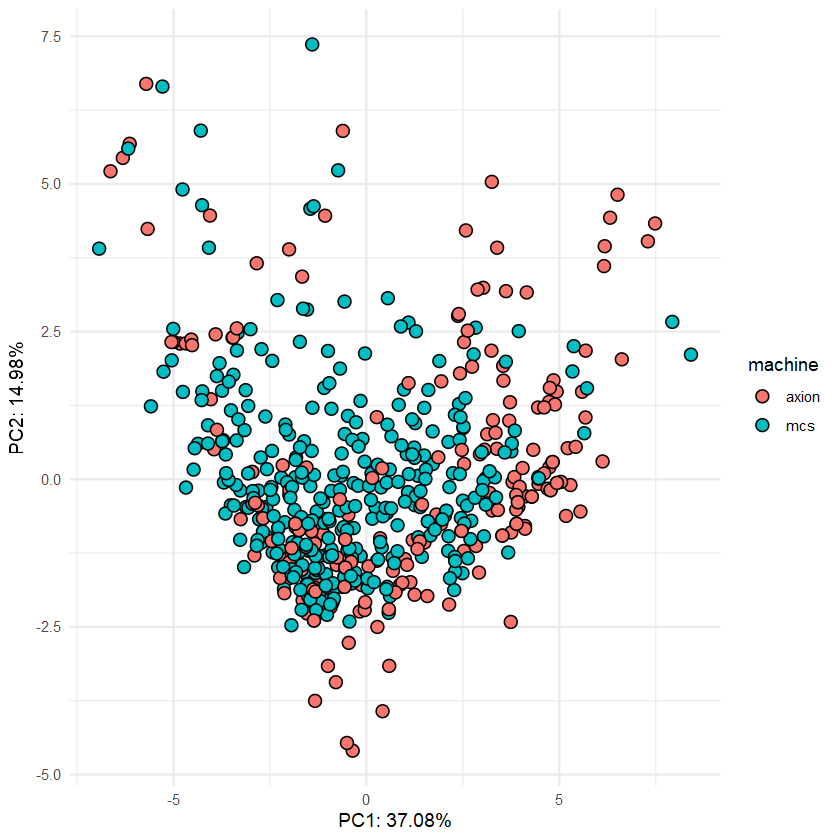

In [17]:
p<-ggplot(pca_pc_metrics, aes(PC1, PC2, fill=cell_line)) +
  geom_point(size=3,shape = 21, # Specify shape and colour as fixed local parameters    
             colour = "black") + scale_fill_manual(values=palette16)+ 
           theme_minimal()+ 
      
  xlab(paste0("PC1: ",var_explained[1],"%")) +
  ylab(paste0("PC2: ",var_explained[2],"%"))
p

ggsave("PCA_controls_line_consistent_var.pdf",bg = "transparent",
                  width = 7,   # inches
                  height = 6.5,
                   plot=p# inches
)

p<-ggplot(pca_pc_metrics, aes(PC1, PC2, fill=machine)) +
  geom_point(size=3,shape = 21, # Specify shape and colour as fixed local parameters    
             colour = "black") + 
           theme_minimal()+ 
      
  xlab(paste0("PC1: ",var_explained[1],"%")) +
  ylab(paste0("PC2: ",var_explained[2],"%"))
p

ggsave("PCA_controls_machine_consistent_var.pdf",bg = "transparent",
                  width = 7,   # inches
                  height = 6.5,
                   plot=p# inches
)

In [18]:
#Data normalization
#if not isogenic pair, then Own_control will be median_controls, considering ALL controls

In [19]:
controls <- controls %>%
  mutate(across(where(is.character), ~ na_if(.,"")))

In [20]:
#group by phenotype first and then all
numeric_var<-names(controls)[sapply(controls, is.numeric)]

median_individual_controls<-controls %>% group_by(Phenotype)   %>% 
             summarise_at(numeric_var, median) %>% as.data.frame()
median_controls<-median_individual_controls %>% 
             summarise_at(numeric_var, median) %>% as.data.frame() #check if median help for the hf nb pronlem: yes
rownames(median_individual_controls)<-median_individual_controls$Phenotype
median_individual_controls<-median_individual_controls[-1]
rownames(median_controls)<-c("median_controls")
all_control_median_of_medians<-rbind(median_individual_controls,median_controls)


write.csv(all_control_median_of_medians,"all_control_median_of_medians.csv")

patients$Own_control<-ifelse(patients$isogenic=="yes",patients$Own_control,"median_controls")
patients_meta<-patients %>%  select(where(is.factor) | where(is.character))
patients_normalized<- merge(patients[final_selected_variables], patients_meta, by = 0)
rownames(patients_normalized)<-patients_normalized$Row.names
patients_normalized<-patients_normalized[-1]
patients_normalized_list<-list()

#define epsilon
all_values <- unlist(all_control_median_of_medians)

# Keep only numeric and positive values
all_values <- as.numeric(all_values)
all_values <- all_values[all_values > 0]

# Find the minimum
epsilon <- min(all_values, na.rm = TRUE) * 0.05
#epsilon <-1e-10
print(epsilon)

[1] 0.0002043145


In [21]:
for (r in rownames(patients_normalized)){
    df<-patients_normalized[r,]
    pool_to_norm<-df[,"Own_control"]
    norm_row<-all_control_median_of_medians[pool_to_norm,final_selected_variables]#all_control_medians
  # Add epsilon to both sample and control, then divide
    num_vars <- colnames(df)[colnames(df) %in% numeric_var]
    #log2 divide
    df[, num_vars] <- log2((df[, num_vars] + epsilon) / (norm_row + epsilon))#log2 for making similar up and downreguation differences
    patients_normalized_list[[r]]<-df
}
patients_normalized_list<-do.call(rbind,patients_normalized_list)

pca_meta_patients_normalized_list <- patients_normalized_list %>%
 select(where(is.factor) | where(is.character))
set.seed(1)

pca_fit_patients_normalized_list <- patients_normalized_list %>%
  select(where(is.numeric)) 
# Identify rows with NA values
rows_with_na <- !complete.cases(pca_fit_patients_normalized_list)

# Output rows with NA values
pca_fit_patients_normalized_list[rows_with_na, ]



Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"


INBI,IEBI_CV,EB_prop,INBI_Std,EB_rate_Std,EB_ISI,Firing_rate_Hz,NB_rate,Spikes_per_EB_Std,EB_rate_Hz,⋯,EB_prop_Std,NB_dur,Spikes_per_EB,EB_Dur_Std,Firing_Rate_in_NB_Hz,IEBI,IEBI_Std,NB_prop,hfNB_and_NB_prop,hfNB_rate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


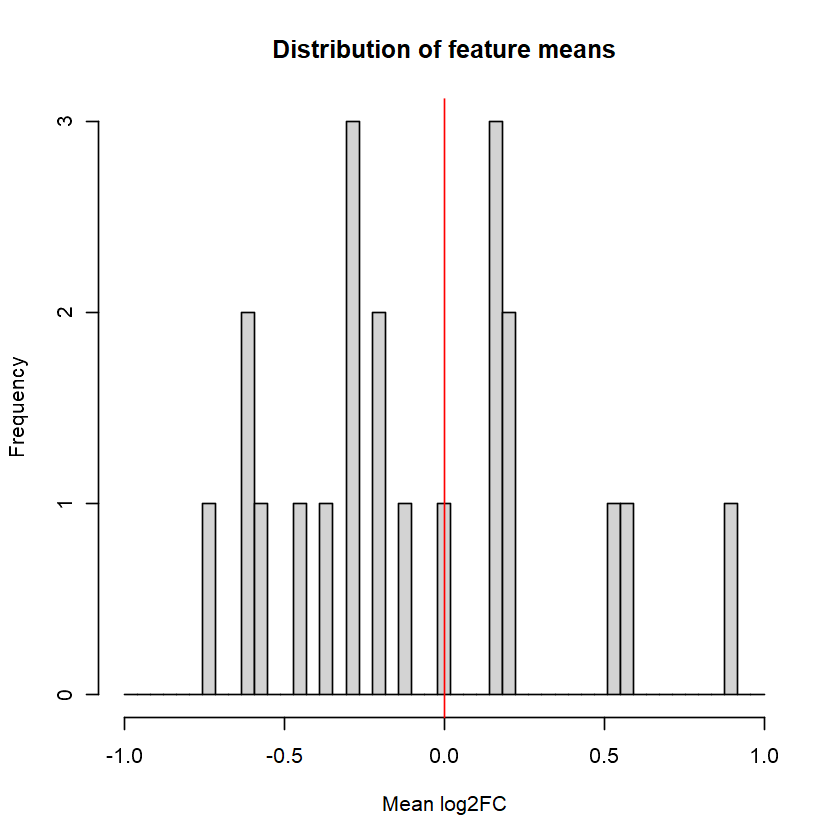

In [22]:
feature_means <- colMeans(pca_fit_patients_normalized_list, na.rm = TRUE)
hist(feature_means, breaks = seq(round(min(feature_means)), round(max(feature_means)), length.out = 50),main = "Distribution of feature means",
     xlab = "Mean log2FC")


abline(v = 0, col = "red")


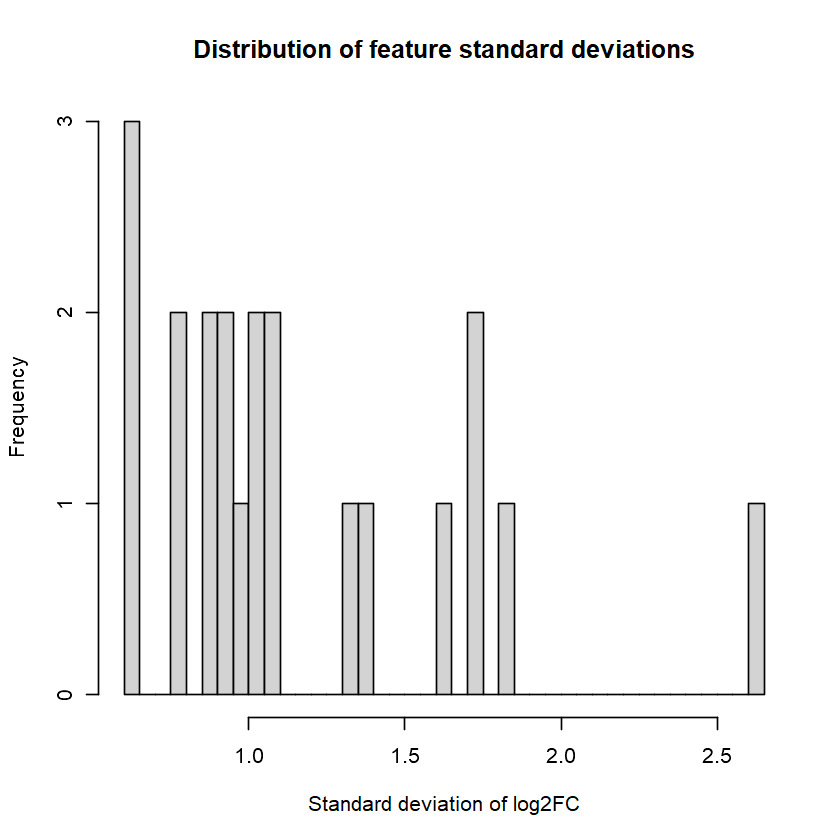

In [23]:
feature_sds <- apply(pca_fit_patients_normalized_list, 2, sd, na.rm = TRUE)

hist(feature_sds, breaks = 50,
     main = "Distribution of feature standard deviations",
     xlab = "Standard deviation of log2FC")


In [24]:
pca_fit_patients_normalized_list<- prcomp(pca_fit_patients_normalized_list, center = FALSE,scale. = TRUE) #not centered to preserve biological zero from log2FC
pca_fit_patients_normalized_list$rotation <- -1*pca_fit_patients_normalized_list$rotation
summ <- summary(pca_fit_patients_normalized_list)
summ_var<-summ$importance[2,]
summ_var<-unname(summ_var[1:21])
pdf("variance_plot_mutated_lines_normalized.pdf", width = 7, height = 5)  # you can change size if needed

# Make the plot
plot(summ_var * 100, type = "b", pch = 19, col = "black",
     xlab = "Principal Component", ylab = "Variance (%)")

# Add a horizontal line at 1%
abline(h = 1, col = "blue", lty = 2, lwd = 2)

dev.off()

pdf 
  2

In [25]:
# Extract the loadings (rotation matrix)
loadings <- pca_fit_patients_normalized_list$rotation
# Extract the proportion of variance explained by each component
explained_variance <- pca_fit_patients_normalized_list$sdev^2 / sum(pca_fit_patients_normalized_list$sdev^2)

setNames(explained_variance, seq_along(explained_variance))

1            2            3            4            5            6 
4.154932e-01 1.895074e-01 1.104616e-01 7.484617e-02 6.013631e-02 3.707711e-02 
           7            8            9           10           11           12 
2.859735e-02 2.527953e-02 2.052960e-02 9.454740e-03 8.163159e-03 7.465576e-03 
          13           14           15           16           17           18 
3.911006e-03 2.798734e-03 2.290203e-03 1.572145e-03 1.236703e-03 5.461834e-04 
          19           20           21 
3.564911e-04 1.932482e-04 8.355934e-05

In [26]:
#PC > #0.4% variance
threshold<-0.004 #0.4% 
selected_components  <- max(which(round(explained_variance,3) >= threshold))
selected_components

[1] 13

In [27]:
pca_pc_metrics<-as.data.frame(pca_fit_patients_normalized_list$x)
pca_pc_metrics$Unique_ID<-rownames(pca_pc_metrics)
pca_pc_metrics<-inner_join(pca_pc_metrics,pca_meta_patients_normalized_list, by="Unique_ID")
rownames(pca_pc_metrics)<-pca_pc_metrics$Unique_ID
var_explained =round((pca_fit_patients_normalized_list$sdev^2 / sum(pca_fit_patients_normalized_list$sdev^2))*100,2)
length(levels(factor(pca_pc_metrics$Phenotype)))
length(levels(factor(pca_pc_metrics$Syndrome)))

[1] 44

[1] 16

In [28]:
# Create a named vector for Phenotypes and their corresponding Colors
phenotype_colors <- setNames(color$Color, color$cell_line)

# Create a named vector for Syndromes and their corresponding MainColors
syndrome_colors <- setNames(color$MainColor, color$Syndrome)

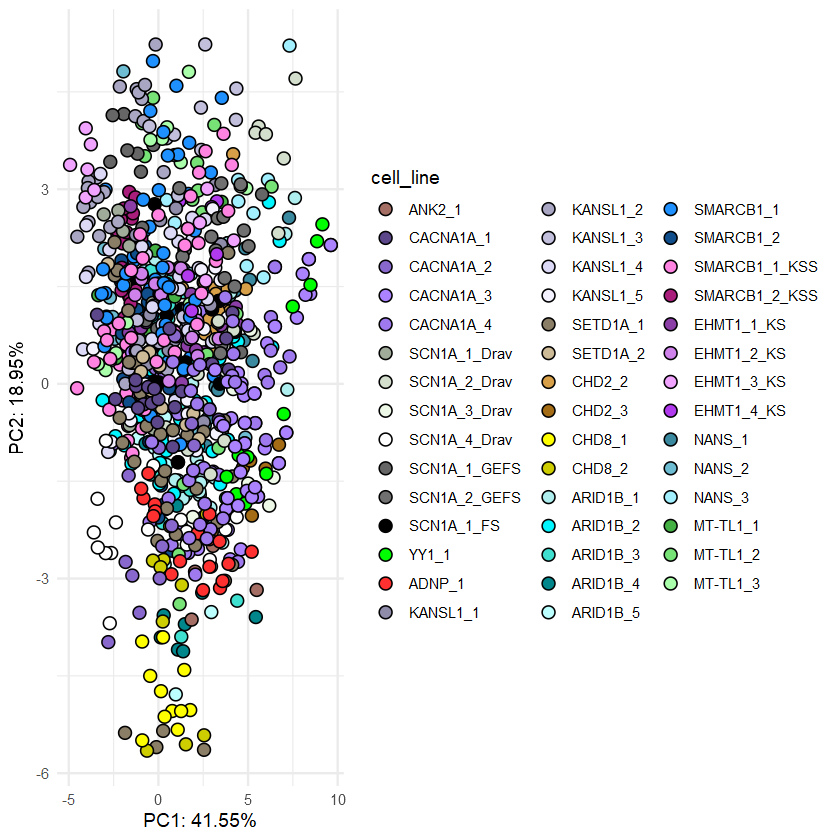

In [29]:
p<-ggplot(pca_pc_metrics, aes(PC1, PC2, fill=cell_line)) +
  geom_point(size=3,shape = 21, # Specify shape and colour as fixed local parameters    
             colour = "black") +  scale_fill_manual(values=phenotype_colors)+ 
           theme_minimal()+ 
      
  xlab(paste0("PC1: ",var_explained[1],"%")) +
  ylab(paste0("PC2: ",var_explained[2],"%"))
p


ggsave("PCA_patients_normalized_line.pdf",bg = "transparent",
                  width = 10,   # inches
                  height = 6.5,
                   plot=p# inches
)

In [30]:
# NEXT SECTION:
# This code performs the following steps:
# 1. UMAP dimensionality reduction on PCA data with specified number of components
# 2. Visualization of UMAP projections colored by cell line and syndrome
# 3. Cosine distance calculations between cell lines and syndromes in UMAP space
# 4. Louvain clustering on k-nearest neighbor graph from UMAP coordinates
# 5. Identifying variables enriched or depleted relative to baseline across clusters
# 6. Visualization of clustering results and cluster distributions

In [31]:
pca_meta_patients <- patients %>%
 select(where(is.factor) | where(is.character))
set.seed(1)

In [32]:
# cosine distance 

calculate_pairwise_distance <- function(cell_line_1, cell_line_2, umap_df) {
    # Extract UMAP points for both cell lines
    umap_1 <- umap_df[umap_df$cell_line == cell_line_1, c("UMAP1", "UMAP2")]
    umap_2 <- umap_df[umap_df$cell_line == cell_line_2, c("UMAP1", "UMAP2")]

    # If either cell line has fewer than two UMAP points, return NA
    if (nrow(umap_1) < 2 | nrow(umap_2) < 2) {
        return(NA)
    }

    # If the cell lines are the same, return 0 for self-comparison
    if (cell_line_1 == cell_line_2) {
        return(0)
    } else {
        # Compute pairwise cosine distances between umap_1 and umap_2
        dist_matrix <- proxy::dist(rbind(umap_1, umap_2), method = "cosine")  
        dist_matrix <- as.matrix(dist_matrix)  # Convert to matrix format
        dist_matrix <- dist_matrix[1:nrow(umap_1), (nrow(umap_1) + 1):ncol(dist_matrix)]  # Subset
        
        return(mean(dist_matrix, na.rm = TRUE))  # Return the mean cosine distance
    }
}


In [33]:
# Color palette for clusters
n_colors <- c("1" = "#9999CC", "2" = "#FF00FF", "3" = "#33CC99", "4" = "#FF9966", 
              "5" = "#FF3300", "6" = "#3399FF", "7" = "#CCFF99")

In [34]:
selected_components

[1] 13

Warning message in dir.create(paste0("PC", n.components)):
"'PC13' already exists"


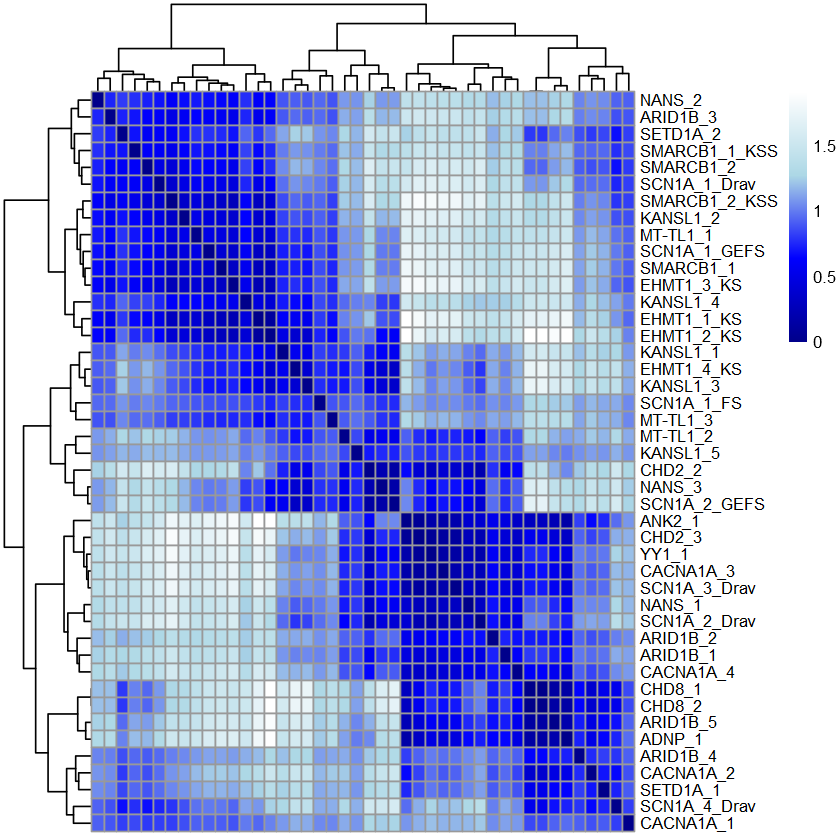

Warning message in dir.create(paste0("PC", n.components, "/", k)):
"'PC13\200' already exists"
Using cell_line, Well_Label, Phenotype, batch, cell_line_batch, machine, PT_all_path, DIV_range, Syndrome, Gene, Identidy, Own_control, isogenic, Remarks, Pool_Kleefstra, Pool_WTC_CHD2, Pool_CACNA1A, Pool_SMARCB1, Pool_ARID1B_2_rescue, Pool_dravet, Unique_ID, PT_all_path_Well_Label, DIV49_sub, dev_sub, color, louvian_clust as id variables



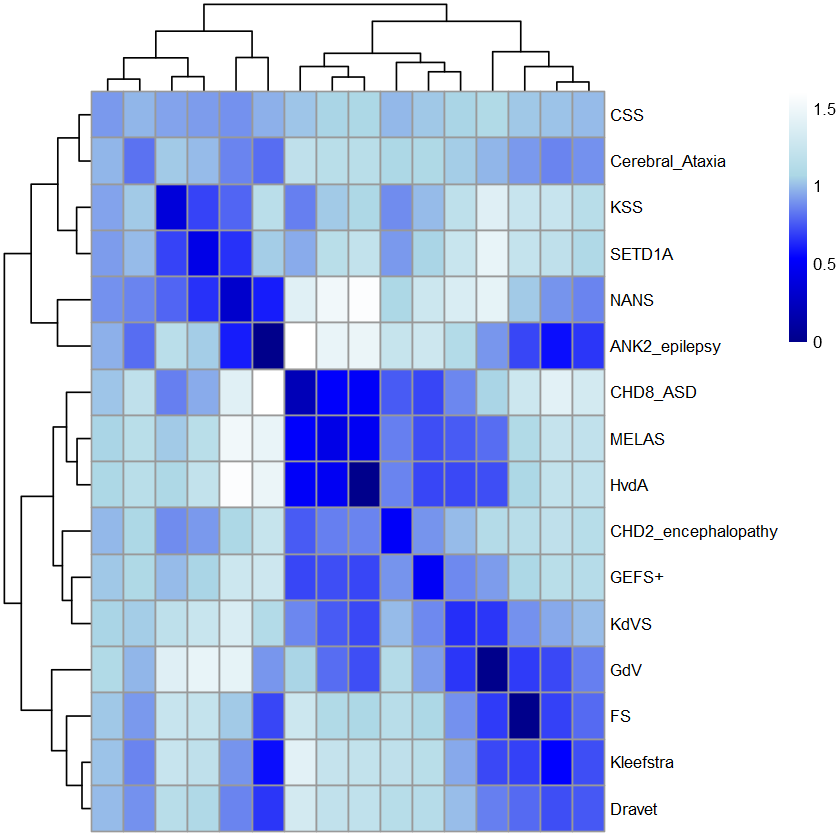

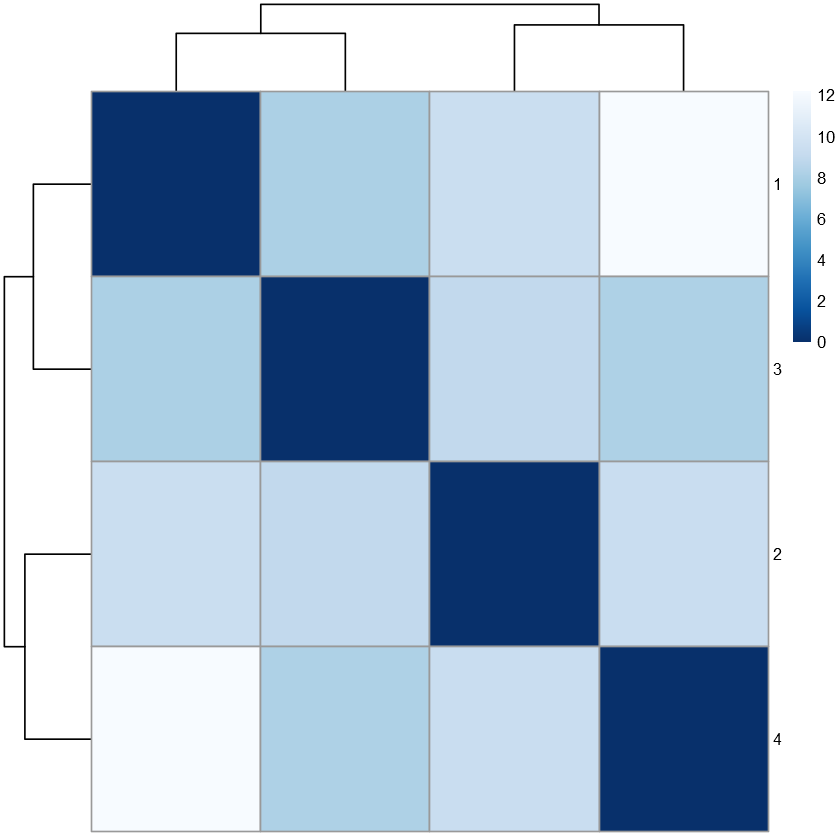

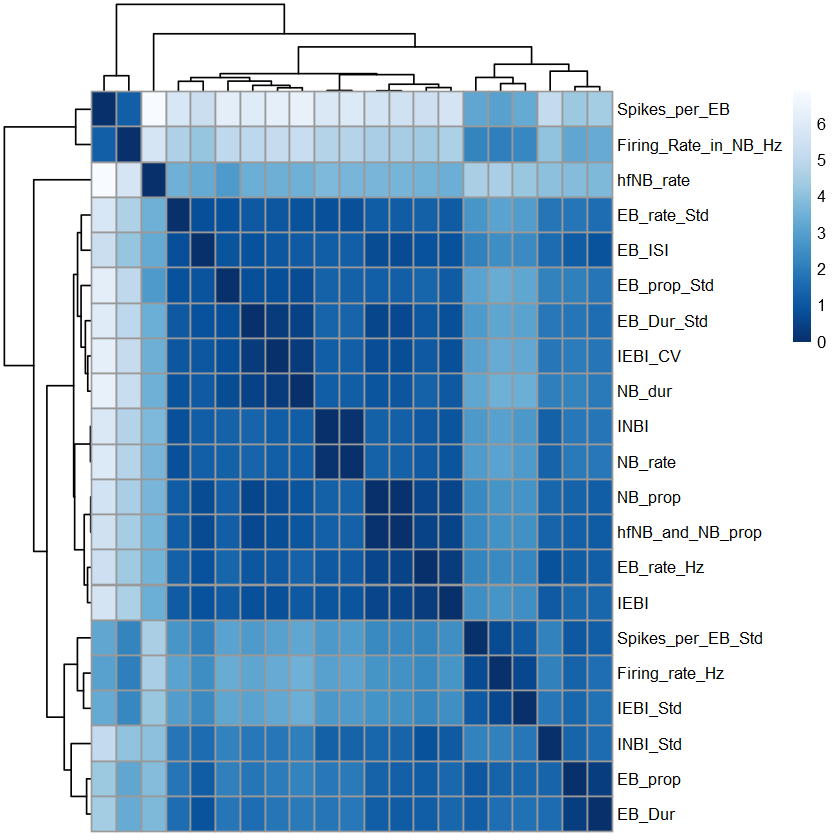

Warning message in dir.create(paste0("PC", n.components, "/", k, "/individual_plots")):
"'PC13\200\individual_plots' already exists"
Warning message in geom_violin(outlier.shape = NA, size = 0.5, colour = "grey", :
"Ignoring unknown parameters: `outlier.shape`"
Warning message in geom_violin(outlier.shape = NA, size = 0.5, colour = "grey", :
"Ignoring unknown parameters: `outlier.shape`"
Warning message in geom_violin(outlier.shape = NA, size = 0.5, colour = "grey", :
"Ignoring unknown parameters: `outlier.shape`"
Warning message in geom_violin(outlier.shape = NA, size = 0.5, colour = "grey", :
"Ignoring unknown parameters: `outlier.shape`"
Warning message in geom_violin(outlier.shape = NA, size = 0.5, colour = "grey", :
"Ignoring unknown parameters: `outlier.shape`"
Warning message in geom_violin(outlier.shape = NA, size = 0.5, colour = "grey", :
"Ignoring unknown parameters: `outlier.shape`"
Warning message in geom_violin(outlier.shape = NA, size = 0.5, colour = "grey", :
"Ignoring u

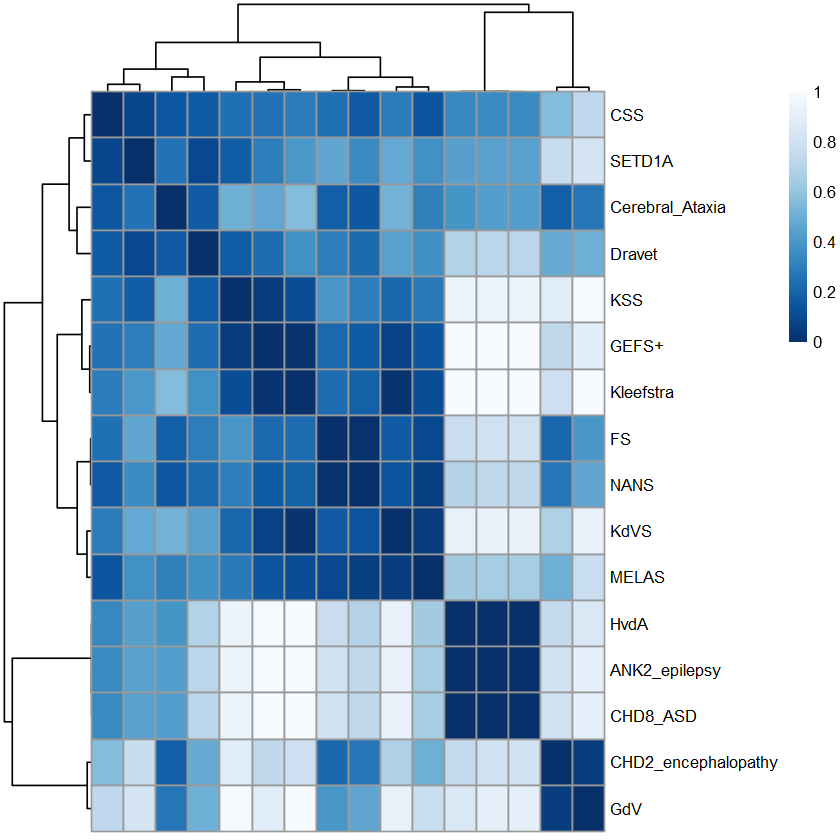

In [36]:
# Main analysis loop for different numbers of PCA components
for (n in selected_components) {#selected_components
  n.components <- n
  dir.create(paste0("PC", n.components))
  
  # STEP 1: Prepare PCA data for UMAP
  pca_pc_metrics_umap <- pca_pc_metrics[, 1:n.components]
  pca_pc_metrics_umap$Unique_ID <- rownames(pca_pc_metrics_umap)
  pca_pc_metrics_umap <- inner_join(pca_pc_metrics_umap, pca_meta_patients, by = "Unique_ID")
  rownames(pca_pc_metrics_umap) <- pca_pc_metrics_umap$Unique_ID
  
  # Order cell lines by syndrome
  pca_pc_metrics_umap <- pca_pc_metrics_umap %>%
    mutate(cell_line = fct_reorder(cell_line, Syndrome, .fun = "first"))
  
  # Extract metadata and numeric data for UMAP
  umap_meta <- pca_pc_metrics_umap %>% select(where(is.factor) | where(is.character))
  umap_fit <- pca_pc_metrics_umap %>% 
    select(where(is.numeric)) %>% 
    umap(config = custom.config)
  
  # Create UMAP dataframe
  umap_df <- umap_fit$layout %>% as.data.frame()
  colnames(umap_df) <- c("UMAP1", "UMAP2")
  umap_df$Unique_ID <- rownames(umap_df)
  umap_df <- inner_join(umap_df, pca_pc_metrics_umap, by = "Unique_ID")
  rownames(umap_df) <- umap_df$Unique_ID
  
  # STEP 2: UMAP visualization by cell line
  p <- ggplot(umap_df, aes(UMAP1, UMAP2, fill = cell_line)) +
    geom_point(size = 3, shape = 21, colour = "black",stroke = 0.2) +
    scale_fill_manual(values = phenotype_colors) +
    theme_minimal() +
    theme(
      panel.background = element_rect(fill = NA, colour = NA),
      plot.background = element_rect(fill = NA, colour = NA)
    )
  
  ggsave(paste0("PC", n.components, "/UMAP_cell_line.pdf"), 
         bg = "transparent", width = 10, height = 5, plot = p)
  
  # STEP 3: UMAP visualization by syndrome
  p <- ggplot(umap_df, aes(UMAP1, UMAP2, fill = Syndrome)) +
    geom_point(size = 3, shape = 21, colour = "black",stroke = 0.2) +
    scale_fill_manual(values = syndrome_colors) +
    theme_minimal() +
    theme(
      panel.background = element_rect(fill = NA, colour = NA),
      plot.background = element_rect(fill = NA, colour = NA)
    )
  
  ggsave(paste0("PC", n.components, "/UMAP_syndrome.pdf"), 
         bg = "transparent", width = 10, height = 5, plot = p)
  
  # STEP 4: Calculate pairwise distances between cell lines and syndromes
  unique_cell_lines <- unique(umap_df$cell_line)
  pairwise_distances_matrix <- matrix(NA, nrow = length(unique_cell_lines), 
                                     ncol = length(unique_cell_lines))
  rownames(pairwise_distances_matrix) <- unique_cell_lines
  colnames(pairwise_distances_matrix) <- unique_cell_lines
  
  # Loop through all pairs of cell lines and calculate distances
  for (i in 1:(length(unique_cell_lines) - 1)) {
    for (j in (i + 1):length(unique_cell_lines)) {
      cell_line_i <- unique_cell_lines[i]
      cell_line_j <- unique_cell_lines[j]
      pairwise_distances_matrix[i, j] <- calculate_pairwise_distance(cell_line_i, cell_line_j, umap_df)
      pairwise_distances_matrix[j, i] <- pairwise_distances_matrix[i, j] # Symmetric distance
    }
  }
  
  diag(pairwise_distances_matrix) <- 0 # Set self-distances to zero
  
  # Plot heatmap for pairwise distances
  colors <- colorRampPalette(c("darkblue", "blue", "lightblue", "white"))(250)
  p <- pheatmap(pairwise_distances_matrix, col = colors, 
                show_colnames = FALSE, show_rownames = TRUE, angle_col = 90)
  
  ggsave(paste0("PC", n.components, "/UMAP_distance_cell_line_cosine.pdf"),
         bg = "transparent", width = 7.5, height = 6, plot = p)

  # Calculate distance between syndromes
  syndrome_names <- unique(umap_df$Syndrome)
  syndrome_dist_matrix <- matrix(NA, nrow = length(syndrome_names), ncol = length(syndrome_names))
  rownames(syndrome_dist_matrix) <- syndrome_names
  colnames(syndrome_dist_matrix) <- syndrome_names
    
  for (i in 1:length(syndrome_names)) {
        for (j in i:length(syndrome_names)) {
            syndrome_i <- syndrome_names[i]
            syndrome_j <- syndrome_names[j]
            
            # Get the cell lines for each syndrome
            cell_lines_i <- unique(umap_df$cell_line[umap_df$Syndrome == syndrome_i])
            cell_lines_j <- unique(umap_df$cell_line[umap_df$Syndrome == syndrome_j])
            
            # Get the pairwise distances between all cell lines within each syndrome
            if (i == j) {
                # Intra-syndrome distance: calculate mean pairwise distance between cell lines within the same syndrome
                dist_subset <- pairwise_distances_matrix[cell_lines_i, cell_lines_i]
                syndrome_dist_matrix[i, j] <- mean(dist_subset, na.rm = TRUE)
            } else {
                # Inter-syndrome distance: calculate mean pairwise distance between cell lines of two different syndromes
                dist_subset <- pairwise_distances_matrix[cell_lines_i, cell_lines_j]
                syndrome_dist_matrix[i, j] <- mean(dist_subset, na.rm = TRUE)
                syndrome_dist_matrix[j, i] <- syndrome_dist_matrix[i, j]  # Fill symmetric value
            }
        }
    }
    
    # Plot heatmap for syndrome distances
  syndrome_dist_matrix[is.na(syndrome_dist_matrix)] <- 0 # This is for syndromes with only one cell line
    
  colors <- colorRampPalette(c( "darkblue","blue","lightblue","white"  ))(250)
  
  p <- pheatmap(syndrome_dist_matrix,
                  col = colors,
                show_colnames = FALSE,  # Hide x-axis labels
              show_rownames = TRUE,   # Keep y-axis labels
                  angle_col = 90)  



  ggsave(paste0("PC",n.components,"/UMAP_distance_syndrome_cosine.pdf"),bg = "transparent",
                  width = 5,   # inches
                  height = 3, plot=p   # inches
                )

    
  # STEP 5: Louvain clustering on UMAP data
  distance_matrix <- as.matrix(dist(umap_df[, 1:2]))
  adj_matrix <- matrix(0, nrow = nrow(distance_matrix), ncol = ncol(distance_matrix))
  Ks <- c(200) # Number of nearest neighbors
  
  set.seed(123)
  for (k in Ks) {
    # Create k-nearest neighbor graph
    for (i in 1:nrow(distance_matrix)) {
      neighbors <- order(distance_matrix[i, ])[2:(k + 1)] # Exclude self
      adj_matrix[i, neighbors] <- 1
    }
    
    # Create graph and run Louvain clustering
    graph <- graph.adjacency(adj_matrix, mode = "undirected")
    louvain_clusters <- cluster_louvain(graph)
    cluster_membership <- membership(louvain_clusters)
    num_clusters <- unique(cluster_membership)
    
    if (length(num_clusters) <= 7) {
      dir.create(paste0("PC", n.components, "/", k))
      umap_df$louvian_clust <- cluster_membership
      umap_df$louvian_clust <- factor(umap_df$louvian_clust)
      # STEP 6: Cluster visualization
      p <- ggplot(umap_df, aes(UMAP1, UMAP2, fill = louvian_clust)) +
        geom_point(size = 3, shape = 21, colour = "black",stroke = 0.2) +
        theme_minimal() +
        scale_fill_manual(values = n_colors) +
        theme(
          panel.background = element_rect(fill = NA, colour = NA),
          plot.background = element_rect(fill = NA, colour = NA)
        )
      
      ggsave(paste0("PC", n.components, "/", k, "/UMAP_cluster.pdf"),
             bg = "transparent", width = 7, height = 5, plot = p)
      
      # STEP 7: Cell line proportions by cluster
      umap_df_syndrome <- split(umap_df, f = umap_df$Syndrome)
      umap_df_syndrome <- lapply(umap_df_syndrome, function(x) {
        table(x$cell_line, x$louvian_clust)
      })
      
      # Calculate percentages per line
     for(df in names(umap_df_syndrome)){
            rel_counts<-umap_df_syndrome[[df]]
            for (i in 1:nrow(rel_counts)){
                rel_counts[i,] <- (prop.table(rel_counts[i,]))*100 }
                rel_counts<-as.data.frame(rel_counts)
                rel_counts$Syndrome<-df
                umap_df_syndrome[[df]]<-rel_counts}
     for(df in names(umap_df_syndrome)){
            data<-umap_df_syndrome[[df]]
            data <- data[data$Freq != "NaN", ]
            umap_df_syndrome[[df]]<-data}
            umap_df_syndrome<-as.data.frame(do.call(rbind,umap_df_syndrome))
            colnames(umap_df_syndrome)<-c("cell_line","cluster","percentage","syndrome")
            p<-ggplot(umap_df_syndrome, aes(x=cell_line, y=percentage, fill = cluster)) + 
                            geom_bar(stat = "identity") + scale_fill_manual(values=n_colors)+
                    theme_minimal()+theme(axis.text.x = element_text(size=7,angle = 45, vjust = 1, 
                        hjust = 1),axis.text.y = element_text(size=7), strip.text = element_text(size = 7), 
                         panel.background = element_rect(fill = NA, colour = NA), panel.grid.minor = element_blank(),
                         plot.background = element_rect(fill = NA, colour = NA)) + facet_wrap(~syndrome,scales = "free",ncol=5)  

                                      
               
            ggsave(paste0("PC",n.components,"/",k,"/proportions_Cell_line.pdf"),bg = "transparent",
                  width = 8,   # inches
                  height = 5,
                       plot=p# inches
                )
      
      # STEP 8: Differences between clusters, compare based on normalized meassurements,compare from zero
      patients_normalized_louvian5 <- left_join(patients_normalized_list,
                                               umap_df[, colnames(umap_df) %in% c("louvian_clust", "Unique_ID")],
                                               by = "Unique_ID")
      patients_normalized_louvian5$louvian_clust <- as.factor(patients_normalized_louvian5$louvian_clust)
      rownames(patients_normalized_louvian5) <- patients_normalized_louvian5$Unique_ID
      
      patients_normalized_louvian5_melted <- melt(patients_normalized_louvian5)

        
      patients_normalized_louvian5_melted_list <- split(patients_normalized_louvian5_melted,
                                                       f = patients_normalized_louvian5_melted$variable)
      
      variables_to_test <- names(patients_normalized_louvian5_melted_list)
      clusters <- levels(patients_normalized_louvian5_melted$louvian_clust)
      all_comparisons <- list()
      
      # Perform statistical testing for each variable and cluster
      for (var in variables_to_test) {
        cluster_list <- list()
        df <- patients_normalized_louvian5_melted_list[[var]]
        
        for (cluster in clusters) {
          df_c <- df[df$louvian_clust == cluster, ]
          results <- lm(value ~ 1, data = df_c)
          results <- summary(results)
          results <- as.data.frame(results$coefficients)
          
          results_2 <- data.frame(
            "intercept" = results[1, 1],
            "p_val" = results[1, 4],
            "evaluated_cluster_number" = cluster,
            "metric" = var,
            "fold_change" = 2^(abs(results[1, 1])),
            "signed_fold_change" = ifelse(results[1, 1] >= 0, 2^(abs(results[1, 1])), -2^(abs(results[1, 1]))),
            "percent_change" = (2^(results[1, 1]) - 1) * 100,
            "estimate" = results[1, 1]
          )
          cluster_list[[cluster]] <- results_2
        }
        cluster_list <- do.call(rbind, cluster_list)
        all_comparisons[[var]] <- cluster_list
      }
      
      all_comparisons <- do.call(rbind, all_comparisons)
      all_comparisons$adj_p <- p.adjust(all_comparisons$p_val, method = "fdr", n = dim(all_comparisons)[1])
      all_comparisons$significant <- ifelse(all_comparisons$estimate > 0 & all_comparisons$adj_p < 0.05, TRUE, FALSE)
      all_comparisons_significant<-all_comparisons[all_comparisons$significant==TRUE,]
      all_comparisons_significant_list<-split(all_comparisons_significant,f=all_comparisons_significant$evaluated_cluster_number)
      write.csv(all_comparisons_significant,paste0("PC",n.components,"/",k,"/","all_comparisons_significant.csv"))
      
     #reorganize variables for subsequen heatmap, based on similarity   
        
     filtered_data <- all_comparisons %>%
                  select(evaluated_cluster_number, metric, estimate)
                
     # Reshape data: Wide format with clusters as rows and metrics as columns
     wide_data <- filtered_data %>%
                  pivot_wider(names_from = metric, values_from = estimate, values_fill = 0)  # Fill missing values with 0
                
     #  Convert evaluated_cluster_number to row names
     wide_data <- wide_data %>%
                  column_to_rownames(var = "evaluated_cluster_number")
                
     # Scale the estimates to give all metrics equal weight
     scaled_data <- scale(wide_data)
                
     #  Compute distance matrix
     cluster_distances <- dist(scaled_data)
                                      
     for_louvian_c_Dists <- stats::dist(cluster_distances)
    
     for_louvian_c_DistsMatrix <- as.matrix(for_louvian_c_Dists)
     colnames(for_louvian_c_DistsMatrix) <- NULL
     colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
            
     pheatmap<-pheatmap(for_louvian_c_DistsMatrix,
                     clustering_distance_rows=for_louvian_c_Dists,
                     clustering_distance_cols=for_louvian_c_Dists,
                     col=colors)
            
     ggsave(paste0("PC",n.components,"/",k,"/","clusters_distances.pdf"),bg = "transparent",
                  width = 3.5,   # inches
                  height = 3,
                       plot=pheatmap# inches
                )   
        
    
            
    order_of_clusters<-pheatmap[[4]][[1]][[3]][[4]][[1]][[9]][[1]]
    order_of_clusters<-rownames(order_of_clusters)
    umap_df$louvian_clust<-factor(umap_df$louvian_clust,levels=order_of_clusters)        
    #reorder clusters basd on similarity    
    patients_normalized_louvian5_melted_list <- lapply(
    patients_normalized_louvian5_melted_list,function(df) {
    df$louvian_clust <- factor(df$louvian_clust, levels = order_of_clusters)
    return(df)
      }
    )
               
        
    # STEP 9: Cluster differences heatmap
    all_comparisons_hm <- all_comparisons[, colnames(all_comparisons) %in% 
                                            c("evaluated_cluster_number", "metric", "signed_fold_change", 
                                              "adj_p", "p_val", "estimate")]
    all_comparisons_hm$evaluated_cluster_number <- as.factor(all_comparisons_hm$evaluated_cluster_number)
    all_comparisons_hm$metric <- as.factor(all_comparisons_hm$metric)
    all_comparisons_hm$r_p_val <- round(all_comparisons_hm$p_val, 2)
    all_comparisons_hm$r_adj_p<-round(all_comparisons_hm$adj_p,2) 
 
            
    all_comparisons_hm$evaluated_cluster_number<-factor(all_comparisons_hm$evaluated_cluster_number, levels=order_of_clusters)
    #TRY to order clusters and variales based on louvian clustering
    clusters<-levels(patients_normalized_louvian5_melted$louvian_clust)
    all_comparisons<-list()
    for (var in variables_to_test){
            cluster_list<-list()
            df<-patients_normalized_louvian5_melted_list[[var]]
                
            for(cluster in clusters){
                df_c <- df[df$louvian_clust == cluster, ] 
                   
                # Fit intercept-only model: value ~ 1, testing mean != 0
                results <- lm(value ~ 1, data = df_c)    
                    
                results<-summary(results)
                results<-as.data.frame(results$coefficients)
                           
                results_2<-data.frame("intercept"=results[1,1],#"estimate"=results[2,1],
                                     "p_val"=results[1,4])  # p-value for intercept #"p_val"=results[2,4] for coef
                results_2$evaluated_cluster_number<-cluster
                results_2$metric<-var
                      
                #compatible with log2
                results_2$fold_change <- 2^(abs(results_2$intercept))  # replaced estimate by intercept interpret directlyy
                    
                results_3<-matrix(results_2["fold_change"])
                rownames(results_3)<-var
                colnames(results_3)<-cluster
                results_3<-as.data.frame(results_3)
                cluster_list[[cluster]]<-results_3
                    
                }
                
                
                
            cluster_list<-do.call(cbind,cluster_list)
            all_comparisons[[var]]<-cluster_list
                
            }
    for_louvian<-do.call(rbind,all_comparisons)
    for_louvian_c_Dists <- stats::dist(for_louvian)
            
    for_louvian_c_DistsMatrix <- as.matrix(for_louvian_c_Dists)
    colnames(for_louvian_c_DistsMatrix) <- NULL
    colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
            
    pheatmap<-pheatmap(for_louvian_c_DistsMatrix,
                     clustering_distance_rows=for_louvian_c_Dists,
                     clustering_distance_cols=for_louvian_c_Dists,
                     col=colors)
            
    order_of_metrics<-pheatmap[[4]][[1]][[3]][[4]][[1]][[9]][[1]]
    order_of_metrics<-rownames(order_of_metrics)
    all_comparisons_hm$metric<-factor(all_comparisons_hm$metric, levels=order_of_metrics)
    hm <- ggplot(all_comparisons_hm, aes(x = evaluated_cluster_number, y = metric)) +
        geom_tile(aes(fill = estimate), color = "black") +
        scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0, limits = c(-4, 4)) +
        geom_text(aes(label = r_p_val), colour = ifelse(all_comparisons_hm$r_p_val < 0.01, "black", alpha("white", 0)),
                  size = 3, angle = 45) +
        theme_minimal() +
        theme(
          legend.key.size = unit(0.5, 'cm'),
          axis.text = element_text(color = "black"),
          legend.key.height = unit(0.5, 'cm'),
          legend.key.width = unit(0.5, 'cm'),
          legend.title = element_text(size = 7),
          legend.text = element_text(size = 7, color = "black"),
          panel.background = element_rect(fill = NA, colour = NA),
          plot.background = element_rect(fill = NA, colour = NA)
        ) +
        xlab("cluster") + ylab(" ")
      
    ggsave(paste0("PC", n.components, "/", k, "/clust_differences.pdf"),
             bg = "transparent", width = 3.5, height = 4, plot = hm)
      
    # STEP 10: Syndrome distribution by cluster

    # louvian5_assigns_prop<-table(umap_df$Syndrome,umap_df$louvian_clust )#later per phenotype to explore
    # #write.csv(louvian5_assigns_prop, paste0("PC",n.components,"/",k,"/","cluster_louvian_syndrome.csv"))
    # for_louvian<-as.matrix(louvian5_assigns_prop)
    
    # for_louvian<-t(apply(for_louvian,1, function(x) x/sum(x)))
            
    # sampleDists <- stats::dist(for_louvian)
            
    # sampleDistMatrix <- as.matrix(sampleDists)
    # colnames(sampleDistMatrix) <- NULL
    # colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
            
    # p<-pheatmap(sampleDistMatrix,
    #                  clustering_distance_rows=sampleDists,
    #                  clustering_distance_cols=sampleDists,
    #                  col=colors)
         
        # Compute cluster proportions per cell line within syndrome
    cellline_props <- umap_df %>%
      group_by(Syndrome, cell_line, louvian_clust) %>%
      summarise(count = n(), .groups = "drop") %>%
      group_by(Syndrome, cell_line) %>%
      mutate(prop = count / sum(count)) %>%
      ungroup()
    
    # Average proportions across cell lines for each syndrome
    syndrome_props_avg <- cellline_props %>%
      group_by(Syndrome, louvian_clust) %>%
      summarise(mean_prop = mean(prop), .groups = "drop") %>%
      tidyr::pivot_wider(names_from = louvian_clust, values_from = mean_prop, values_fill = 0)
    
    # Compute distance matrix based on averaged proportions
    syndrome_matrix <- as.matrix(syndrome_props_avg[, -1])  # remove Syndrome column
    rownames(syndrome_matrix) <- syndrome_props_avg$Syndrome
    sampleDists <-proxy::dist(syndrome_matrix, method = "cosine")# dist(syndrome_matrix)
    sampleDistMatrix <- as.matrix(sampleDists)
                         ##
    colnames(sampleDistMatrix) <- NULL
    colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
            
    p<-pheatmap(sampleDistMatrix,
                     clustering_distance_rows=sampleDists,
                     clustering_distance_cols=sampleDists,
                     col=colors)
         

    ggsave(paste0("PC", n.components, "/", k, "/Syndrome_hier_clust_cell_line_average.pdf"), plot = p, bg = "transparent", width = 5, height = 3)

    louvian_order<-p[[4]][[1]][[3]][[4]][[1]][[9]][[1]]
            
    louvian_order<-rownames(louvian_order)
    rel_counts <- table(umap_df$Syndrome,umap_df$louvian_clust )
    # calculate the relative counts
    for (i in 1:nrow(rel_counts)){
        rel_counts[i,] <- (prop.table(rel_counts[i,]))*100 }
            
        # make a dataframe of the relative counts
        dg <- as.data.frame(rel_counts)
        colnames(dg) <- c("Syndrome", "cluster", "percentage")
        dg$Syndrome<-factor(dg$Syndrome, levels=louvian_order)
        dg$cluster<-factor(dg$cluster, levels=order_of_clusters)
                         
    p <- ggplot(dg, aes(x = Syndrome, y = percentage, fill = cluster)) +
        geom_bar(stat = "identity") +
        scale_fill_manual(values = n_colors) +
        theme_minimal() +
        theme(axis.text.x = element_text(size = 10, angle = 45, vjust = 1, hjust = 1))
      
    ggsave(paste0("PC", n.components, "/", k, "/Syndrome_louvian_proportions_distance_cell_line_average.pdf"),
             bg = "transparent", width = 7, height = 5, plot = p)
      
      # STEP 11: Individual variable plots
    dir.create(paste0("PC", n.components, "/", k, "/individual_plots"))
      
    for (var in names(patients_normalized_louvian5_melted_list)) {
        df <- patients_normalized_louvian5_melted_list[[var]]
        plot <- ggplot(df, aes(x = louvian_clust, y = value, fill = louvian_clust, group = louvian_clust)) +
          geom_violin(outlier.shape = NA, size = 0.5, colour = "grey", alpha = 0.5) +
          stat_summary(fun = "median", geom = "crossbar", color = "grey") +
          scale_fill_manual(values = n_colors) +
          xlab("") + ylab("") +
          geom_point(position = position_jitterdodge(), alpha = 1, shape = 21, size = 0.3) +
          theme_minimal() +
          theme(
            axis.text.x = element_text(size = 8, color = "black"),
            axis.text.y = element_text(size = 8, color = "black"),
            axis.title = element_text(size = 8),
            text = element_text(size = 7),
            panel.background = element_rect(fill = NA, colour = NA),
            plot.background = element_rect(fill = NA, colour = NA)
          ) +
          ggtitle(paste0(var)) +
          theme(legend.position = "none")
        
        ggsave(paste0("PC", n.components, "/", k, "/individual_plots/", var, ".pdf"),
               bg = "transparent", width = 2, height = 2, plot = plot)
      }
    # Combine all melted data into one data frame
    all_df <- do.call(rbind, patients_normalized_louvian5_melted_list)

    facet_plot <- ggplot(all_df, aes(x = louvian_clust, y = value, fill = louvian_clust)) +
      geom_violin(outlier.shape = NA, size = 0.5, colour = "grey", alpha = 0.5) +
      stat_summary(fun = "median", geom = "crossbar", color = "grey") +
      geom_point(position = position_jitterdodge(), alpha = 1, shape = 21, size = 0.3) +
      scale_fill_manual(values = n_colors) +
      facet_wrap(~variable, scales = "free_y", ncol = 3) +
      theme_minimal() +
      theme(
        axis.text.x = element_text(size = 7, angle = 45, hjust = 1),
        axis.text.y = element_text(size = 7),
        strip.text = element_text(size = 7),
        panel.background = element_rect(fill = NA, colour = NA),
        plot.background = element_rect(fill = NA, colour = NA)
      ) +
      xlab("Cluster") +
      ylab("Normalized value")

    ggsave(
      paste0("PC", n.components, "/", k, "/individual_plots/all_variables.pdf"),
      bg = "transparent", width = 8, height = 12, plot = facet_plot)
    } else {
      print(paste("Number of clusters is too high:", num_clusters))
    }
  }
}

In [ ]:
patients_normalized_list["D:/2024/Patient_Paper/PT_all_v2/Developmental/DIV28/202312_WTC_SMARCB1-PAT_SMARCB1-CRISPR/109-4920_F7_242",1:21]

In [ ]:
umap_df[umap_df$Phenotype=="FAM001_DRAV",c("PT_all_path_Well_Label","louvian_clust")]